In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, label_binarize, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Flatten, Dense, Dropout, Input,
    SimpleRNN, LSTM, Bidirectional,
    Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add,
    Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, BatchNormalization, Activation,
    Reshape,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [216]:
# Importing the CSV file
csvfile = pd.read_csv('dataset.csv')

In [217]:
csvfile.head(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.1685,838.49817,861.8681,865.4945
1,p1,Calm,840.5128,851.79486,847.3626,844.94507
2,p1,Calm,819.9634,823.18680,815.5311,833.2601
3,p1,Calm,838.0952,842.12450,848.97437,850.58606
4,p1,Calm,849.7802,849.78020,829.6337,838.49817
5,p1,Calm,834.0659,847.76556,839.304,844.94507
6,p1,Calm,808.2784,864.68866,877.5824,867.50916
7,p1,Calm,813.1135,848.97437,865.4945,836.8865
8,p1,Calm,823.5897,826.81320,888.86444,884.43225
9,p1,Calm,801.8315,874.76190,864.2857,826.0073


In [218]:
csvfile.tail(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
18998,p9,Bored,912.6374,831.64840,794.57874,946.08057
18999,p9,Bored,822.381,842.52747,906.1905,825.2015
19000,p9,Bored,890.4762,846.15390,858.24176,906.99634
19001,p9,Bored,841.31866,877.17950,843.3333,834.87177
19002,p9,Bored,916.26373,883.62640,743.4066,887.6557
19003,p9,Bored,865.89746,836.48350,858.24176,877.1795
19004,p9,Bored,874.7619,857.43590,831.2454,896.9231
19005,p9,Bored,906.99634,897.72894,925.5311,939.6337
19006,p9,Bored,795.38464,823.99270,979.12085,731.7216
19007,p9,Bored,801.4286,846.55676,857.8388,784.10254


In [219]:
# Determining the Dimensions
shape = csvfile.shape
print("Samples  (Rows) :", shape[0])
print("Features (Cols) :", shape[1])
#print(csvfile.info())

Samples  (Rows) : 19008
Features (Cols) : 6


In [220]:
csvfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     19008 non-null  object 
 1   Classification  19008 non-null  object 
 2   RAW_TP9         19008 non-null  object 
 3   RAW_AF7         19008 non-null  float64
 4   RAW_AF8         19008 non-null  object 
 5   RAW_TP10        19008 non-null  object 
dtypes: float64(1), object(5)
memory usage: 891.1+ KB


In [221]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 1 numerical features: 

['RAW_AF7']


In [222]:
# Imputing missing / invalid numeric values
impute = SimpleImputer(missing_values=np.nan, strategy='median')
imputing = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

# Coerce non-numeric placeholders like '#NUM!' to NaN so median imputation works
for col in imputing:
    csvfile[col] = pd.to_numeric(csvfile[col], errors='coerce')

# Fit on the subset once, then write back
csvfile[imputing] = impute.fit_transform(csvfile[imputing])

# Quick sanity check
csvfile[imputing].isna().sum()

RAW_TP9     0
RAW_AF7     0
RAW_AF8     0
RAW_TP10    0
dtype: int64

In [223]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


In [224]:
#Selecting categoricalfeatures
categorical_data=csvfile.select_dtypes(include= 'object')

#append the features of categorical_data to list
categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


In [225]:
# Transposed stats for numerical features

numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,19008.0,841.603622,95.344705,0.000000,822.38100,844.94507,864.28570,1650.0
RAW_AF7,19008.0,851.929095,73.676821,8.058608,836.08057,850.98900,865.09155,1650.0
RAW_AF8,19008.0,850.789558,170.811337,0.000000,830.03660,850.18317,869.52380,1650.0
RAW_TP10,19008.0,840.568612,107.104516,0.402930,821.17220,844.94507,864.68866,1650.0


In [226]:
# Transposed stats for categorical features

categorical_data.describe().T

,count,unique,top,freq
Participant,19008,31,p4,625
Classification,19008,4,Happy,4791


In [227]:
# Removing the 'Participants'
csvfile = csvfile.drop(['Participant'], axis = 1)

In [228]:
numerical_data.var()

RAW_TP9      9090.612718
RAW_AF7      5428.273991
RAW_AF8     29176.513005
RAW_TP10    11471.377361
dtype: float64

In [229]:
numerical_data.skew()

RAW_TP9    -0.596327
RAW_AF7     0.459461
RAW_AF8    -0.204876
RAW_TP10   -0.421103
dtype: float64

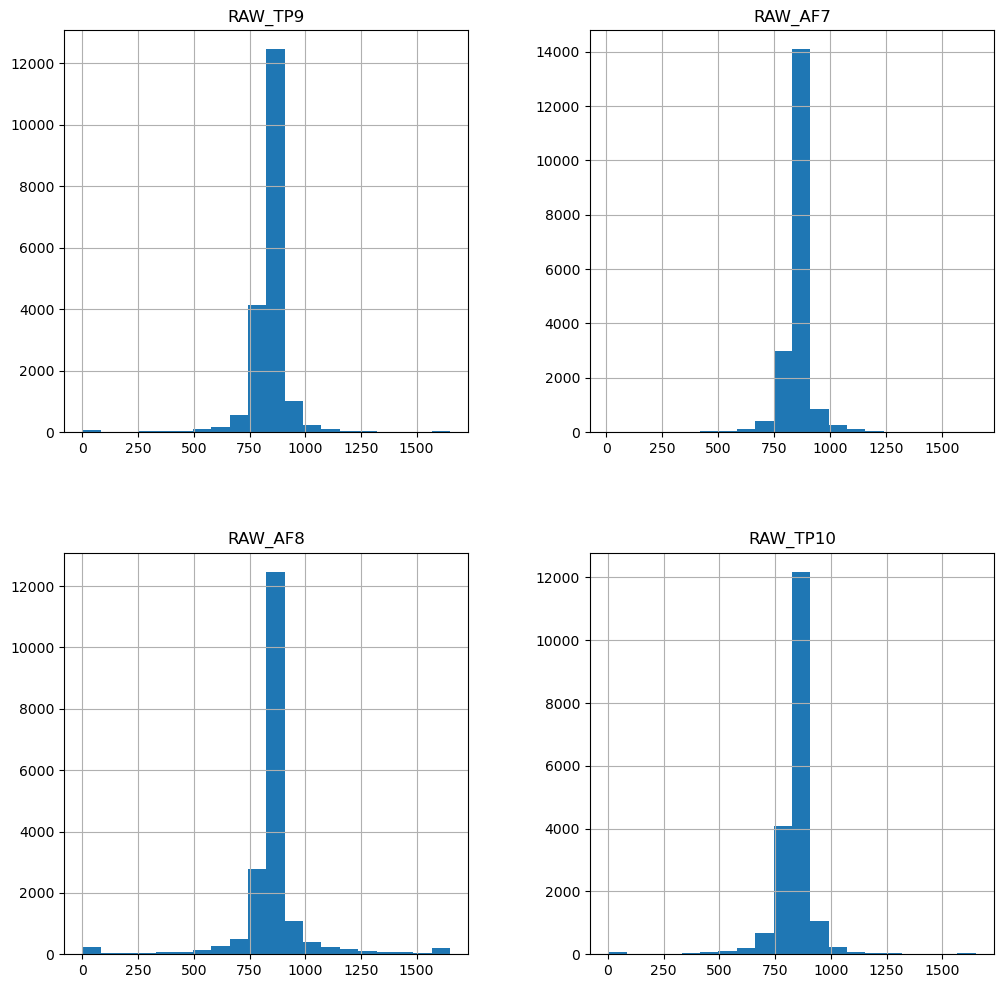

In [230]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

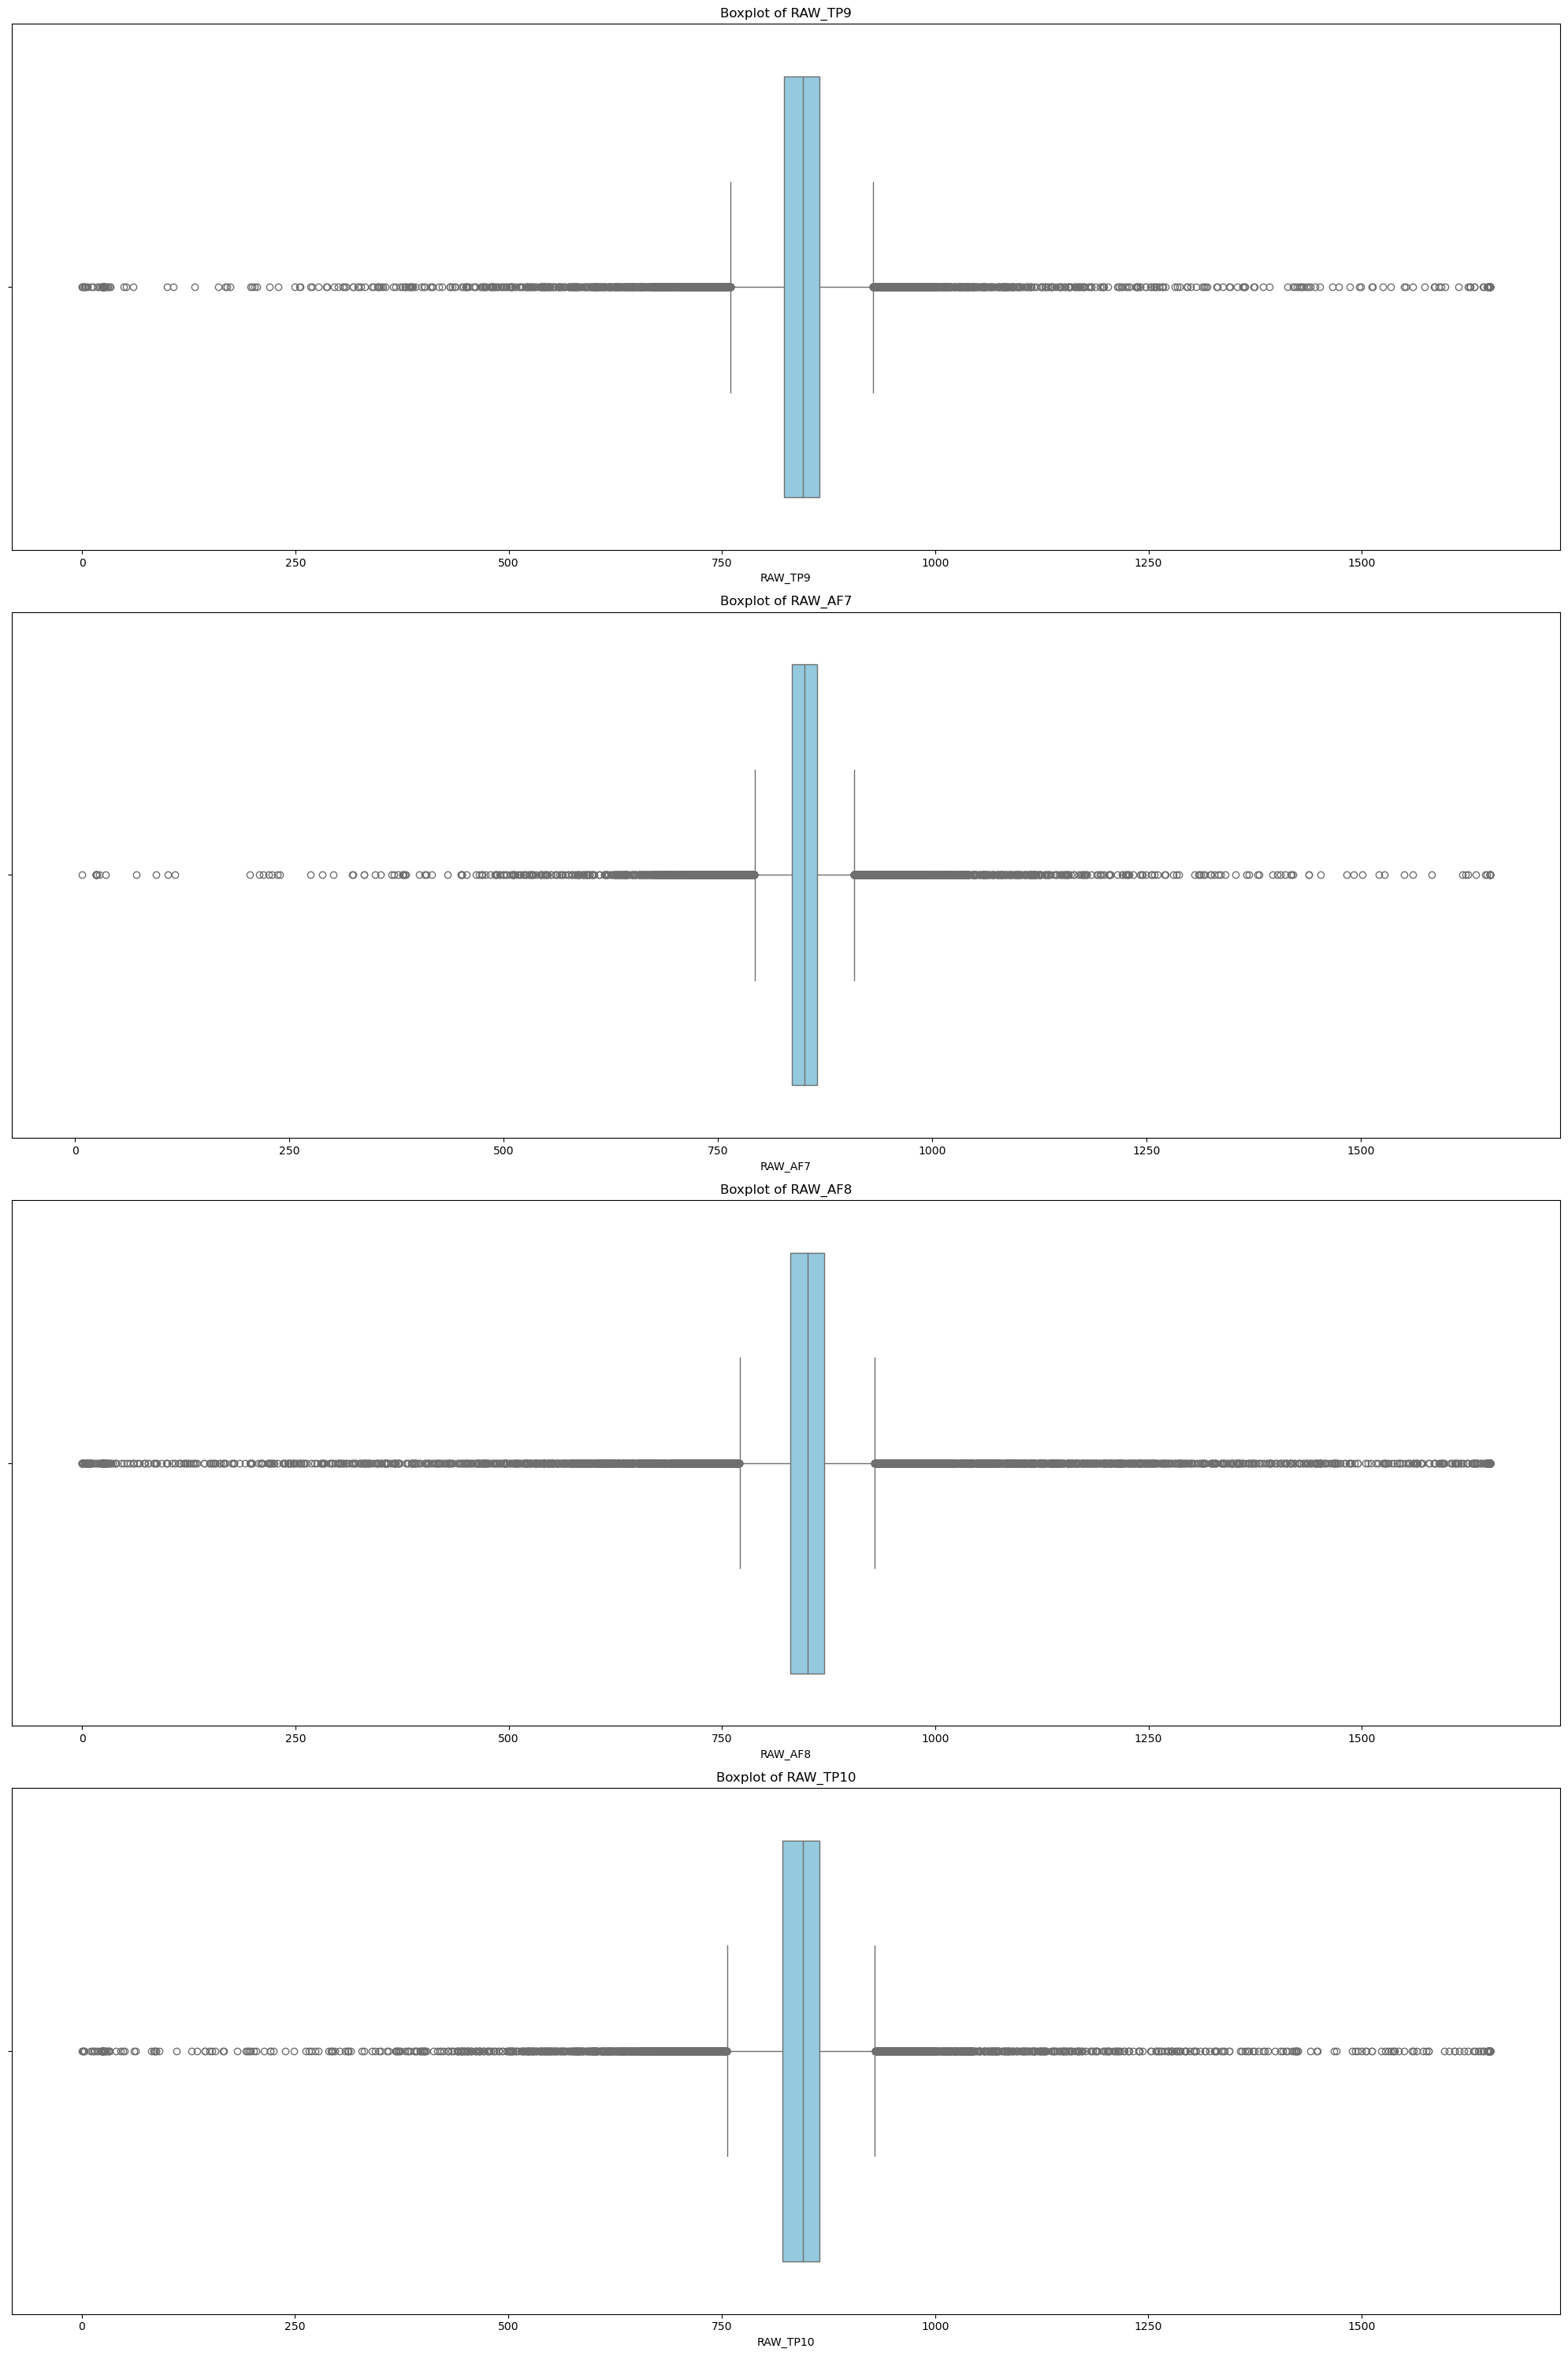

In [231]:
# Select only numerical columns for boxplot analysis
numeric_cols = csvfile.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure
plt.figure(figsize=(20, 30))

# Plot boxplots for each numerical feature including the target variable 'OUTCOME'
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=csvfile[col], color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.show()

In [232]:
numerical_data.nunique()

RAW_TP9     1420
RAW_AF7     1264
RAW_AF8     2058
RAW_TP10    1533
dtype: int64

In [233]:
# Checking null values
csvfile.isnull().sum()

Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [234]:
# unique values counts
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


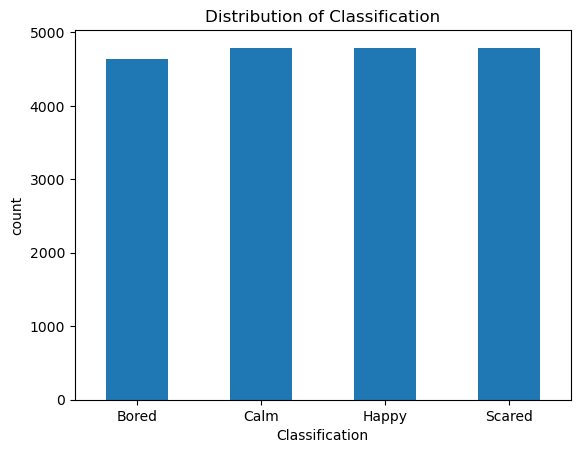

In [235]:
for col in categorical_features:
    if col!='Participant':
        plt.title(f'Distribution of {col}')
        categorical_data[col].value_counts().sort_index().plot(kind='bar', rot=0, xlabel=col,ylabel='count')
        plt.show()

In [236]:
# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()
correlation_matrix


,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.118820,0.011490,0.479958
RAW_AF7,0.118820,1.000000,0.122938,0.094927
RAW_AF8,0.011490,0.122938,1.000000,0.001761
RAW_TP10,0.479958,0.094927,0.001761,1.000000


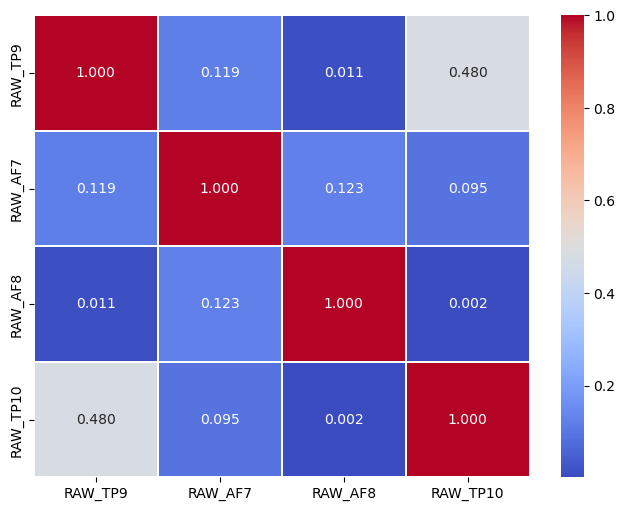

In [237]:
# Plotting the heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

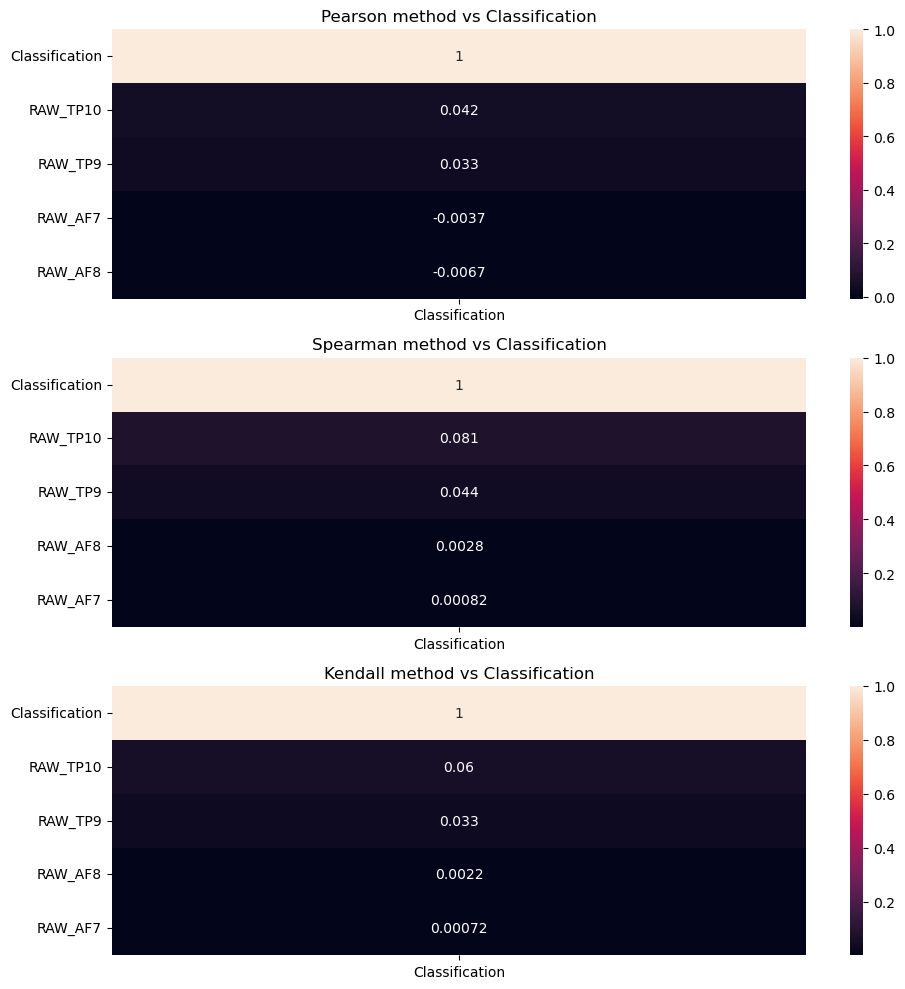

In [238]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
## Correlation coefficient using different methods

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Build a numeric-only dataframe for correlation, and ensure the target is numeric too
corr_df = csvfile.select_dtypes(include='number').copy()
target_numeric_col = target_col
if target_col not in corr_df.columns:
    # Target is not numeric yet; convert to numeric codes just for correlation purposes
    corr_df[target_col] = pd.factorize(csvfile[target_col])[0]

def corr_with_target(method: str) -> pd.DataFrame:
    corr_mat = corr_df.corr(method=method)
    return corr_mat[[target_numeric_col]].sort_values(by=target_numeric_col, ascending=False)

corr1 = corr_with_target('pearson')
corr2 = corr_with_target('spearman')
corr3 = corr_with_target('kendall')

# setting titles for each plot
ax[0].set_title(f'Pearson method vs {target_col}')
ax[1].set_title(f'Spearman method vs {target_col}')
ax[2].set_title(f'Kendall method vs {target_col}')

## Generating heatmaps of each method
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.tight_layout()
plt.show()

In [239]:
# Check Imbalance in data

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Count instances per class (works for numeric or string labels)
class_counts = csvfile[target_col].value_counts(dropna=False).sort_index()

imbalance_df = (
    class_counts
    .rename('count')
    .to_frame()
    .assign(percentage=lambda d: (d['count'] / d['count'].sum()) * 100)
    .reset_index()
    .rename(columns={'index': target_col})
)

imbalance_df

,Classification,count,percentage
0,Bored,4644,24.431818
1,Calm,4787,25.184133
2,Happy,4791,25.205177
3,Scared,4786,25.178872


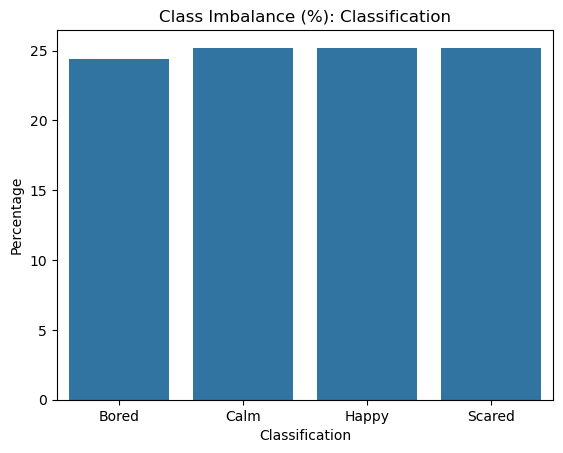

In [240]:
# Plot imbalance percentages
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

sns.barplot(data=imbalance_df, x=target_col, y='percentage')
plt.title(f'Class Imbalance (%): {target_col}')
plt.xlabel(target_col)
plt.ylabel('Percentage')
plt.show()

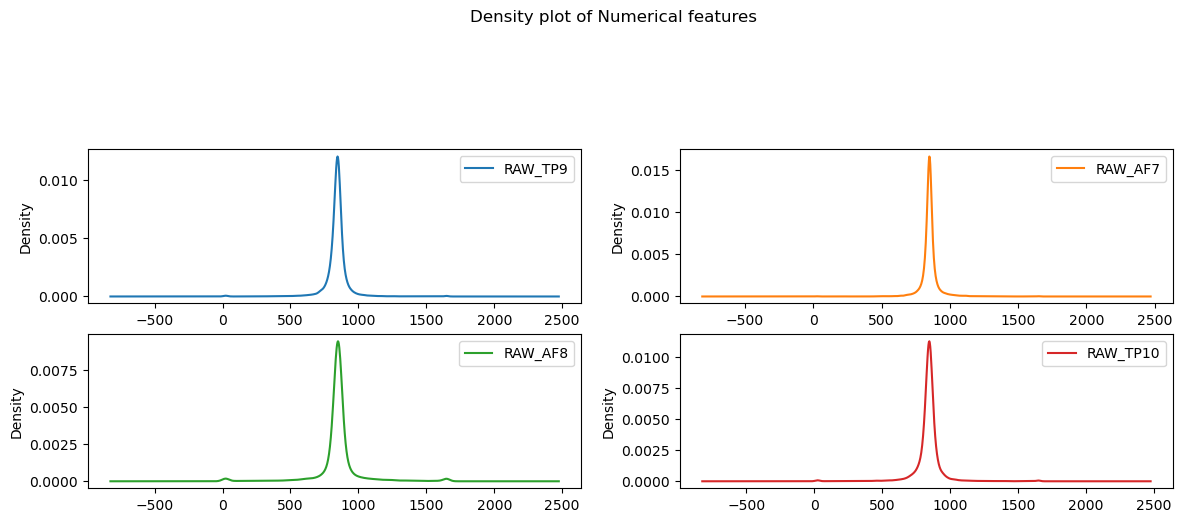

In [241]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

In [242]:
# Checking null values
csvfile.isnull().sum()

Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [243]:
# # Encoding to numbers
csvfile['Classification'] = csvfile['Classification'].map({'Bored':3,'Happy':2,'Scared':1,'Calm':0})

In [244]:
csvfile.head(10)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817
5,0,834.0659,847.76556,839.30400,844.94507
6,0,808.2784,864.68866,877.58240,867.50916
7,0,813.1135,848.97437,865.49450,836.88650
8,0,823.5897,826.81320,888.86444,884.43225
9,0,801.8315,874.76190,864.28570,826.00730


In [245]:
# X = Input, Y = Output
x = csvfile.drop(columns=['Classification'])
y = csvfile['Classification']

In [246]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

Classification        1.242260
RAW_TP9            9090.612718
RAW_AF7            5428.273991
RAW_AF8           29176.513005
RAW_TP10          11471.377361
dtype: float64

In [247]:
# Scaling removes outliers and adjusts bias

In [248]:
# Train Test Split
# 30% For testing, 70% For training
# Random State =  5 for splitting in same way everytime (Consistency)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5, stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(13305, 4) (13305,)
(5703, 4) (5703,)


In [249]:
# Robust Scaling
scaler = RobustScaler()

In [250]:
# Scaling train and test inputs
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [251]:
csvfile.head(5)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817


In [252]:
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))

per-feature minimum before scaling:
 RAW_TP9      0.402930
RAW_AF7     24.578754
RAW_AF8      0.000000
RAW_TP10     0.805861
dtype: float64
per-feature maximum before scaling:
 RAW_TP9     1650.0
RAW_AF7     1650.0
RAW_AF8     1650.0
RAW_TP10    1650.0
dtype: float64


In [253]:
print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

per-feature minimum after scaling:
 [-20.35923814 -28.4861196  -21.53062882 -19.57944102]
per-feature maximum after scaling:
 [19.38836484 27.5416756  20.25511666 18.6728982 ]


In [254]:
csvfile.head(5)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817


/usr/lib/python3/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


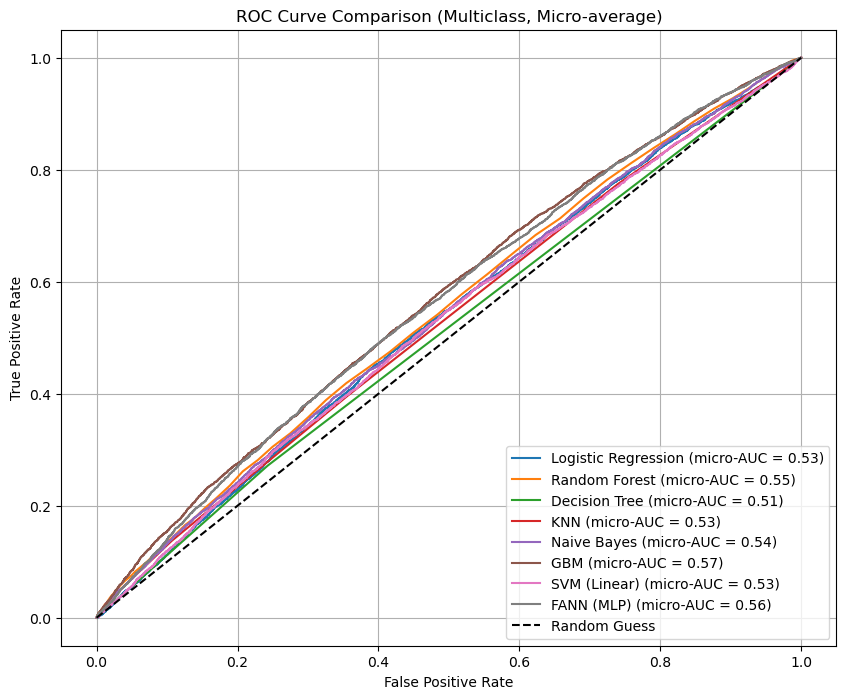

In [255]:
# Determining which model to use (multiclass ROC: micro-average)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=5),
    "SVM (Linear)": LinearSVC(class_weight='balanced', random_state=5),
    "FANN (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        random_state=5,
    ),
}

def get_score_matrix(fitted_model, X):
    # Prefer probabilities when available; fall back to decision_function (e.g., LinearSVC)
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X)
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X)
    else:
        raise TypeError(f"Model {type(fitted_model).__name__} has neither predict_proba nor decision_function")

    scores = np.asarray(scores)
    if scores.ndim == 1:
        # Binary case: convert (n_samples,) -> (n_samples, 1) for consistent ravel() behavior
        scores = scores.reshape(-1, 1)
    return scores

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_score = get_score_matrix(model, X_test_scaled)  # (n_samples, n_classes) or (n_samples, 1)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [256]:
# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

y_prediction = logistic_model.predict(X_test_scaled)

log_acc = accuracy_score(y_test, y_prediction)
print('Logistic Regression Accuracy =', log_acc)

Logistic Regression Accuracy = 0.2665263896194985


In [257]:
# FANN (MLPClassifier)
fann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    random_state=5,
 )
fann_model.fit(X_train_scaled, y_train)

y_pred_fann = fann_model.predict(X_test_scaled)

fann_acc = accuracy_score(y_test, y_pred_fann)
print('FANN (MLP) Accuracy =', fann_acc)

FANN (MLP) Accuracy = 0.291074872873926


In [258]:
# SVM (LinearSVC)
svm_model = LinearSVC(class_weight='balanced', random_state=5, dual=False, max_iter=5000)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

svm_acc = accuracy_score(y_test, y_pred_svm)
print('SVM (Linear) Accuracy =', svm_acc)

SVM (Linear) Accuracy = 0.2710853936524636


In [259]:
# Gradient Boosting (GBM)
gbm_model = GradientBoostingClassifier(random_state=5)
gbm_model.fit(X_train_scaled, y_train)

y_pred_gbm = gbm_model.predict(X_test_scaled)

gbm_acc = accuracy_score(y_test, y_pred_gbm)
print('GBM Accuracy =', gbm_acc)

GBM Accuracy = 0.3005435735577766


In [260]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb = nb_model.predict(X_test_scaled)

nb_acc = accuracy_score(y_test, y_pred_nb)
print('Naive Bayes Accuracy =', nb_acc)

Naive Bayes Accuracy = 0.28511309836927934


In [261]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, y_pred_knn)
print('KNN Accuracy =', knn_acc)

KNN Accuracy = 0.271436086270384


In [262]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=5)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

dt_acc = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy =', dt_acc)

Decision Tree Accuracy = 0.26880589163598106


In [263]:
# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy =', rf_acc)

Random Forest Accuracy = 0.28826933193056287


In [282]:
# Neural Network (multiclass)
num_classes = y.nunique()  # should be 4 for: Calm/Bored/Happy/Scared

# One-hot encode target labels to match TensorFlow's expected input
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Build the model
input_shape = X_train_scaled.shape[1]
model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
# Making sure to not overfit so that it doesnt perform bad on unseen data
model.add(Dense(256, activation='relu'))
# 2 hidden layers with neurons 512 and 256 each
model.add(Dense(num_classes, activation='softmax'))
# Multiclass output: one probability per class

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate the model
loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f"Test Accuracy: {nn_acc * 100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test_scaled)
nn_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# Evaluation
print("Neural Network Accuracy:", nn_acc)

Epoch 1/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2774 - loss: 1.4014 - val_accuracy: 0.2938 - val_loss: 1.3760
Epoch 2/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2890 - loss: 1.3806 - val_accuracy: 0.2983 - val_loss: 1.3765
Epoch 3/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2905 - loss: 1.3785 - val_accuracy: 0.2787 - val_loss: 1.3742
Epoch 4/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2949 - loss: 1.3751 - val_accuracy: 0.2938 - val_loss: 1.3766
Epoch 5/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2875 - loss: 1.3763 - val_accuracy: 0.2900 - val_loss: 1.3731
Epoch 6/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2938 - loss: 1.3751 - val_accuracy: 0.3125 - val_loss: 1.3709
Epoch 7/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2939 - loss: 1.3739 - val_accuracy: 0.3156 - val_loss: 1.3717
Epoch 8/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3044 - loss: 1.3713 - val_accuracy: 0.

In [269]:
# DeepConvNet (adapted to 1-channel "EEG" representation)
# Self-contained: can be run independently once X_train_scaled/X_test_scaled and y_train/y_test exist.
if 'X_train_scaled' not in globals() or 'X_test_scaled' not in globals():
    raise NameError("Run the train/test split + scaling cells first (need X_train_scaled and X_test_scaled).")
if 'y_train' not in globals() or 'y_test' not in globals():
    raise NameError("Run the train/test split cell first (need y_train and y_test).")

# Quick TensorFlow gradient sanity check for conv2d itself (bypasses Keras variables)
x0 = tf.random.normal([2, 1, 4, 1])
w0 = tf.Variable(tf.random.normal([1, 4, 1, 1]))
with tf.GradientTape() as t0:
    y0 = tf.nn.conv2d(x0, w0, strides=[1, 1, 1, 1], padding='SAME', data_format='NHWC')
    l0 = tf.reduce_sum(y0)
g0 = t0.gradient(l0, w0)
print('tf.nn.conv2d gradient is None?', g0 is None)
if g0 is None:
    raise RuntimeError(
        'Your TensorFlow install is not providing gradients for conv2d ops. '
        'EEGNet/DeepConvNet require conv gradients. '
        'Fix by using a proper virtualenv/conda env and reinstalling tensorflow.'
    )

timesteps = int(np.asarray(X_train_scaled).shape[1])
X_train_seq = np.asarray(X_train_scaled, dtype=np.float32).reshape(-1, timesteps, 1)
X_test_seq = np.asarray(X_test_scaled, dtype=np.float32).reshape(-1, timesteps, 1)

y_train_np = np.asarray(y_train).astype(np.int32)
y_test_np = np.asarray(y_test).astype(np.int32)
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Expected shape: (batch, channels, samples, 1)
X_train_eeg = X_train_seq.reshape(-1, 1, timesteps, 1)
X_test_eeg = X_test_seq.reshape(-1, 1, timesteps, 1)

# Pool conservatively so we never collapse the width dimension to zero
pool_w = 2 if timesteps >= 2 else 1
kernel_w = max(3, min(5, timesteps))

deepconvnet_model = Sequential([
    Input(shape=(1, timesteps, 1)),
    Conv2D(25, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Conv2D(50, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Flatten(),
    Dense(num_classes, activation='softmax'),
])

deepconvnet_model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
 )

deepconvnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=25, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0,
 )
_, deepconvnet_acc = deepconvnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"DeepConvNet Accuracy = {deepconvnet_acc:.4f}")

tf.nn.conv2d gradient is None? False
DeepConvNet Accuracy = 0.2976


In [271]:
# EEGNet (adapted to 1-channel "EEG" representation)
# This cell is self-contained so it can be run even if you didn't run the setup cells above.
if 'X_train_scaled' not in globals() or 'X_test_scaled' not in globals():
    raise NameError("Run the train/test split + scaling cells first (need X_train_scaled and X_test_scaled).")
if 'y_train' not in globals() or 'y_test' not in globals():
    raise NameError("Run the train/test split cell first (need y_train and y_test).")

timesteps = int(np.asarray(X_train_scaled).shape[1])
X_train_seq = np.asarray(X_train_scaled, dtype=np.float32).reshape(-1, timesteps, 1)
X_test_seq = np.asarray(X_test_scaled, dtype=np.float32).reshape(-1, timesteps, 1)

y_train_np = np.asarray(y_train).astype(np.int32)
y_test_np = np.asarray(y_test).astype(np.int32)
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Expected shape: (batch, channels, samples, 1)
X_train_eeg = X_train_seq.reshape(-1, 1, timesteps, 1)
X_test_eeg = X_test_seq.reshape(-1, 1, timesteps, 1)

kern_len = max(3, min(64, timesteps))
F1 = 8
D = 2
F2 = F1 * D

inp = Input(shape=(1, timesteps, 1))
x = Conv2D(F1, (1, kern_len), padding='same', use_bias=False)(inp)
x = BatchNormalization()(x)
x = DepthwiseConv2D((1, 1), depth_multiplier=D, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = SeparableConv2D(F2, (1, max(3, kern_len // 2)), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
out = Dense(num_classes, activation='softmax')(x)
eegnet_model = tf.keras.Model(inputs=inp, outputs=out)

eegnet_model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
eegnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=25, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0,
 )
_, eegnet_acc = eegnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"EEGNet Accuracy = {eegnet_acc:.4f}")

EEGNet Accuracy = 0.2848


In [279]:
# "Mambular"-inspired gated causal Conv1D stack (Keras 3 compatible)
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

class GLU(Layer):
    def call(self, inputs):
        a, b = tf.split(inputs, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)

def mambular_block(x, d_model: int, kernel_size: int = 7, dropout: float = 0.2):
    h = Conv1D(filters=2 * d_model, kernel_size=kernel_size, padding='causal')(x)
    h = GLU()(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    return Add()([x, h])

d_model_m = 64
inp = Input(shape=(timesteps, 1))
x = Dense(d_model_m)(inp)
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(7, timesteps))
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(15, timesteps))
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)
mambular_model = Model(inp, out)

mambular_acc = train_eval_keras(mambular_model, 'Mambular')

Mambular Accuracy = 0.2728


In [276]:
# Transformer (lightweight encoder over feature-timesteps)
d_model = 64
num_heads = 4
ff_dim = 128

inp = Input(shape=(timesteps, 1))
x = Dense(d_model)(inp)

# Simple learnable positional bias via a trainable vector added per timestep
pos = tf.range(start=0, limit=timesteps, delta=1)
pos_emb = tf.keras.layers.Embedding(input_dim=timesteps, output_dim=d_model)(pos)
x = x + pos_emb
x = LayerNormalization()(x)

attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_out])
x = LayerNormalization()(x)

ffn = Dense(ff_dim, activation='relu')(x)
ffn = Dropout(0.2)(ffn)
ffn = Dense(d_model)(ffn)
x = Add()([x, ffn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
transformer_model = tf.keras.Model(inputs=inp, outputs=out)
transformer_acc = train_eval_keras(transformer_model, 'Transformer')

Transformer Accuracy = 0.2644


In [275]:
# LSTM
lstm_model = Sequential([
    Input(shape=(timesteps, 1)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
lstm_acc = train_eval_keras(lstm_model, 'LSTM')

LSTM Accuracy = 0.2844


In [274]:
# RNN (SimpleRNN)
rnn_model = Sequential([
    Input(shape=(timesteps, 1)),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])
rnn_acc = train_eval_keras(rnn_model, 'RNN')

RNN Accuracy = 0.2858


In [273]:
# Deep Learning models (sequence/CNN-style)
# Treat each feature as a timestep: (n_samples, n_features, 1)
timesteps = X_train_scaled.shape[1]
X_train_seq = X_train_scaled.astype(np.float32).reshape(-1, timesteps, 1)
X_test_seq = X_test_scaled.astype(np.float32).reshape(-1, timesteps, 1)

y_train_np = np.asarray(y_train).astype(np.int32)
y_test_np = np.asarray(y_test).astype(np.int32)
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

def train_eval_keras(model, name: str, epochs: int = 25, batch_size: int = 32):
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    history = model.fit(
        X_train_seq, y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )
    loss, acc = model.evaluate(X_test_seq, y_test_np, verbose=0)
    print(f"{name} Accuracy = {acc:.4f}")
    return acc

In [291]:
# Hybrid model: CNN + BiLSTM with Self-Attention
if 'X_train_seq' not in globals() or 'y_train_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (it defines X_train_seq/X_test_seq and y_train_np/y_test_np).")

# Lightweight CNN front-end + BiLSTM + MultiHead self-attention
k1 = min(5, int(timesteps))
k2 = min(3, int(timesteps))
stride2 = 2 if int(timesteps) >= 2 else 1

inp = Input(shape=(int(timesteps), 1))
x = Conv1D(64, kernel_size=k1, padding='same', activation='relu')(inp)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=k2, padding='same', activation='relu', strides=stride2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(int(num_classes), activation='softmax')(x)

cnn_bilstm_attn_model = tf.keras.Model(inputs=inp, outputs=out)
cnn_bilstm_attn_acc = train_eval_keras(cnn_bilstm_attn_model, 'CNN-BiLSTM + Attention')

CNN-BiLSTM + Attention Accuracy = 0.2904


In [293]:
print('Logistic Regression Accuracy =', log_acc)
print('Random Forest Accuracy       =', rf_acc)
print('Neural Network Accuracy      =', nn_acc)

# Extra models added between Logistic Regression and Random Forest
print('Decision Tree Accuracy       =', dt_acc)
print('KNN Accuracy                 =', knn_acc)
print('Naive Bayes Accuracy         =', nb_acc)
print('GBM Accuracy                 =', gbm_acc)
print('SVM (Linear) Accuracy        =', svm_acc)
print('FANN (MLP) Accuracy          =', fann_acc)

# Deep learning models (feature-as-sequence)
print('RNN Accuracy                 =', rnn_acc)
print('LSTM Accuracy                =', lstm_acc)
print('Transformer Accuracy         =', transformer_acc)
print('Mambular Accuracy            =', mambular_acc)
print('EEGNet Accuracy              =', eegnet_acc)
print('DeepConvNet Accuracy         =', deepconvnet_acc)
print('CNN-BiLSTM + Attention Acc   =', cnn_bilstm_attn_acc)

Logistic Regression Accuracy = 0.2665263896194985
Random Forest Accuracy       = 0.28826933193056287
Neural Network Accuracy      = 0.30071893334388733
Decision Tree Accuracy       = 0.26880589163598106
KNN Accuracy                 = 0.271436086270384
Naive Bayes Accuracy         = 0.28511309836927934
GBM Accuracy                 = 0.3005435735577766
SVM (Linear) Accuracy        = 0.2710853936524636
FANN (MLP) Accuracy          = 0.291074872873926
RNN Accuracy                 = 0.285814493894577
LSTM Accuracy                = 0.2844116985797882
Transformer Accuracy         = 0.2644222378730774
Mambular Accuracy            = 0.27283886075019836
EEGNet Accuracy              = 0.2847624123096466
DeepConvNet Accuracy         = 0.29756268858909607
CNN-BiLSTM + Attention Acc   = 0.29037347435951233


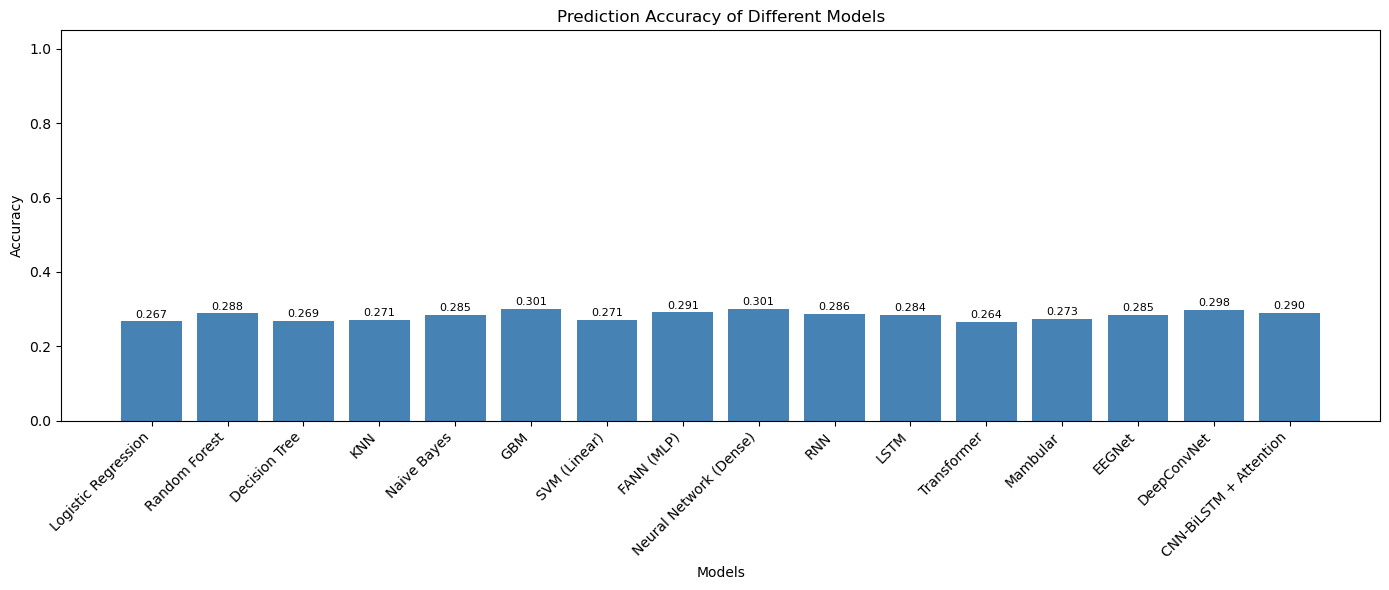

In [294]:
# Accuracy comparison across models
model_acc = {
    'Logistic Regression': log_acc,
    'Random Forest': rf_acc,
    'Decision Tree': dt_acc,
    'KNN': knn_acc,
    'Naive Bayes': nb_acc,
    'GBM': gbm_acc,
    'SVM (Linear)': svm_acc,
    'FANN (MLP)': fann_acc,
    'Neural Network (Dense)': nn_acc,
    'RNN': rnn_acc,
    'LSTM': lstm_acc,
    'Transformer': transformer_acc,
    'Mambular': mambular_acc,
    'EEGNet': eegnet_acc,
    'DeepConvNet': deepconvnet_acc,
    'CNN-BiLSTM + Attention': cnn_bilstm_attn_acc,
}

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

# Display the accuracy scores on top of the bars
for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Interpretetion i.e. Evaluation
labels = sorted(y.unique())
print("Logistic Regression:")
print()
print(classification_report(y_test, y_prediction, target_names=[str(l) for l in labels], zero_division=0))
print("------------------------------------------------------")
print()
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=[str(l) for l in labels], zero_division=0))
print("------------------------------------------------------")
print()
print("Neural Network:")
print(classification_report(y_test, nn_pred, target_names=[str(l) for l in labels], zero_division=0))

Logistic Regression:

              precision    recall  f1-score   support

           0       0.27      0.29      0.28      1436
           1       0.27      0.22      0.24      1436
           2       0.26      0.17      0.20      1438
           3       0.26      0.39      0.31      1393

    accuracy                           0.27      5703
   macro avg       0.27      0.27      0.26      5703
weighted avg       0.27      0.27      0.26      5703

------------------------------------------------------

Random Forest:
              precision    recall  f1-score   support

           0       0.29      0.31      0.30      1436
           1       0.31      0.30      0.30      1436
           2       0.27      0.26      0.27      1438
           3       0.27      0.26      0.26      1393

    accuracy                           0.28      5703
   macro avg       0.28      0.28      0.28      5703
weighted avg       0.28      0.28      0.28      5703

-------------------------------------